<h2> Download Dataset </h2>

In [1]:
# !pip install --upgrade xarray zarr gcsfs google-auth

# from google.colab import auth
# auth.authenticate_user()

# import xarray as xr
# import gcsfs

# try:
#     era5 = xr.open_zarr(
#         "gs://gcp-public-data-arco-era5/ar/1959-2022-full_37-1h-0p25deg-chunk-1.zarr-v2",
#         chunks={'time': 48},
#         consolidated=True
#     )
#     print("Dataset loaded successfully!")
#     print(era5)
# except Exception as e:
#     print("Error loading dataset:", e)


In [2]:
# era5

In [3]:
# subset_temperature = era5['2m_temperature'].sel(
#     latitude=[40.0, 20.0],
#     longitude=280.0,
#     time=slice("2020-01-01", "2021-06-30")
# )

# subset_temperature_computed = subset_temperature.compute()

# df = subset_temperature_computed.to_dataframe().reset_index()
# df.to_csv("subset_temperature.csv", index=False)

# from google.colab import files
# files.download("subset_temperature.csv")

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from datetime import datetime
import matplotlib.pyplot as plt

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')
# base_path = '/content/drive/My Drive/Colab Notebooks/'
print(torch.__version__)
print(torch.cuda.is_available())

2.5.0
True


<h2> Load and Filter the Data </h2>

In [6]:
df = pd.read_csv('subset_temperature_2yrs.csv', parse_dates=['time'])
df.head()

,time,latitude,longitude,2m_temperature
0,2020-01-01 00:00:00,40.0,280.0,274.95590
1,2020-01-01 00:00:00,20.0,280.0,299.77255
2,2020-01-01 01:00:00,40.0,280.0,275.06668
3,2020-01-01 01:00:00,20.0,280.0,299.77100
4,2020-01-01 02:00:00,40.0,280.0,274.62810


In [7]:
loc1 = df[(df['latitude'] == 40.0) & (df['longitude'] == 280.0)].copy()
loc2 = df[(df['latitude'] == 20.0) & (df['longitude'] == 280.0)].copy()

loc1 = loc1.sort_values('time')
loc2 = loc2.sort_values('time')

temp_loc1 = loc1['2m_temperature'].values
temp_loc2 = loc2['2m_temperature'].values

time_loc1 = loc1['time'].values
time_loc2 = loc2['time'].values

combined_data = np.concatenate([temp_loc1, temp_loc2], axis=0)
combined_times = np.concatenate([time_loc1, time_loc2], axis=0)
combined_times = pd.to_datetime(combined_times)

<h2> Normalization Based on Combined Data </h2>

In [8]:
mean_val = combined_data.mean()
std_val = combined_data.std()

temp_loc1_norm = (temp_loc1 - mean_val) / (std_val + 1e-8)
temp_loc2_norm = (temp_loc2 - mean_val) / (std_val + 1e-8)

<h2> Train/Test Split by Time </h2>

In [9]:
split_date = datetime(2021, 1, 1)

# For location 1
mask1_train = loc1['time'] < split_date
mask1_test = loc1['time'] >= split_date
train_data_loc1 = temp_loc1_norm[mask1_train.values]
test_data_loc1 = temp_loc1_norm[mask1_test.values]
train_times_loc1 = loc1['time'].values[mask1_train.values]
test_times_loc1 = loc1['time'].values[mask1_test.values]

# For location 2
mask2_train = loc2['time'] < split_date
mask2_test = loc2['time'] >= split_date
train_data_loc2 = temp_loc2_norm[mask2_train.values]
test_data_loc2 = temp_loc2_norm[mask2_test.values]
train_times_loc2 = loc2['time'].values[mask2_train.values]
test_times_loc2 = loc2['time'].values[mask2_test.values]

train_data_combined = np.concatenate([train_data_loc1, train_data_loc2], axis=0)

<h2> Create PyTorch Datasets </h2>

In [10]:
class TemperatureDataset(Dataset):
    def __init__(self, data, seq_length=24):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_length]
        y = self.data[idx+self.seq_length]
        x = torch.tensor(x, dtype=torch.float32).unsqueeze(-1)
        y = torch.tensor(y, dtype=torch.float32)
        return x, y

seq_length = 24
train_dataset = TemperatureDataset(train_data_combined, seq_length=seq_length)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=1)

<h2> Define the LSTM Model </h2>

In [11]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

<h2> Training </h2>

In [12]:
import time
start_time = time.time()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cuda")
model = LSTMModel(input_size=1, hidden_size=64, num_layers=2).to(device)

if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs for DataParallel")
    model = nn.DataParallel(model)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:
epochs = 15
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(x_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_loss:.4f}")

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution Time: {execution_time} seconds")

Epoch [1/15], Train Loss: 0.1655
Epoch [2/15], Train Loss: 0.0168
Epoch [3/15], Train Loss: 0.0072
Epoch [4/15], Train Loss: 0.0055
Epoch [5/15], Train Loss: 0.0048
Epoch [6/15], Train Loss: 0.0039
Epoch [7/15], Train Loss: 0.0038
Epoch [8/15], Train Loss: 0.0037
Epoch [9/15], Train Loss: 0.0037
Epoch [10/15], Train Loss: 0.0033
Epoch [11/15], Train Loss: 0.0033
Epoch [12/15], Train Loss: 0.0032
Epoch [13/15], Train Loss: 0.0032
Epoch [14/15], Train Loss: 0.0033
Epoch [15/15], Train Loss: 0.0031
Execution Time: 12.282605409622192 seconds


<h2> Predict </h2>

In [14]:
test_dataset_loc1 = TemperatureDataset(test_data_loc1, seq_length=seq_length)
test_dataset_loc2 = TemperatureDataset(test_data_loc2, seq_length=seq_length)

test_loader_loc1 = DataLoader(test_dataset_loc1, batch_size=128, shuffle=False, num_workers=1)
test_loader_loc2 = DataLoader(test_dataset_loc2, batch_size=128, shuffle=False, num_workers=1)

model.eval()

def predict_and_plot(test_dataset, test_loader, test_times, location_label):
    # Generate predictions
    all_preds = []
    all_trues = []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(x_batch).squeeze()
            all_preds.append(y_pred.cpu().numpy())
            all_trues.append(y_batch.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_trues = np.concatenate(all_trues)

    # Inverse normalization
    all_preds_original = all_preds * std_val + mean_val
    all_trues_original = all_trues * std_val + mean_val

    pred_times = test_times[seq_length:]

    plt.figure(figsize=(15, 5))
    plt.plot(pred_times, all_trues_original, label='True Temperature', color='blue')
    plt.plot(pred_times, all_preds_original, label='Predicted Temperature', color='red', alpha=0.7)
    plt.xlabel('Time')
    plt.ylabel('Temperature')
    plt.title(f'True vs. Predicted Temperature for {location_label}')
    plt.legend()
    plt.grid(True)
    plt.show()

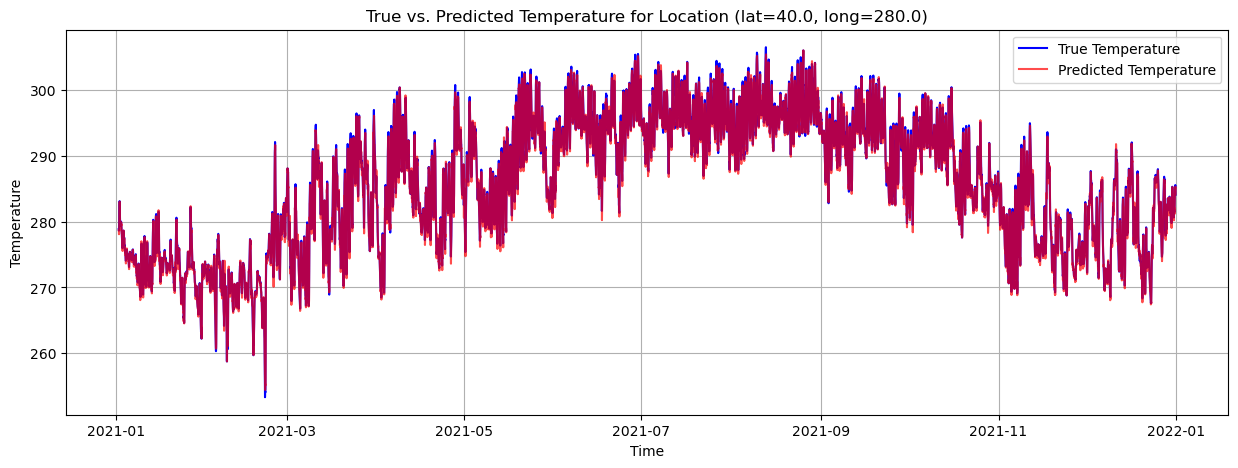

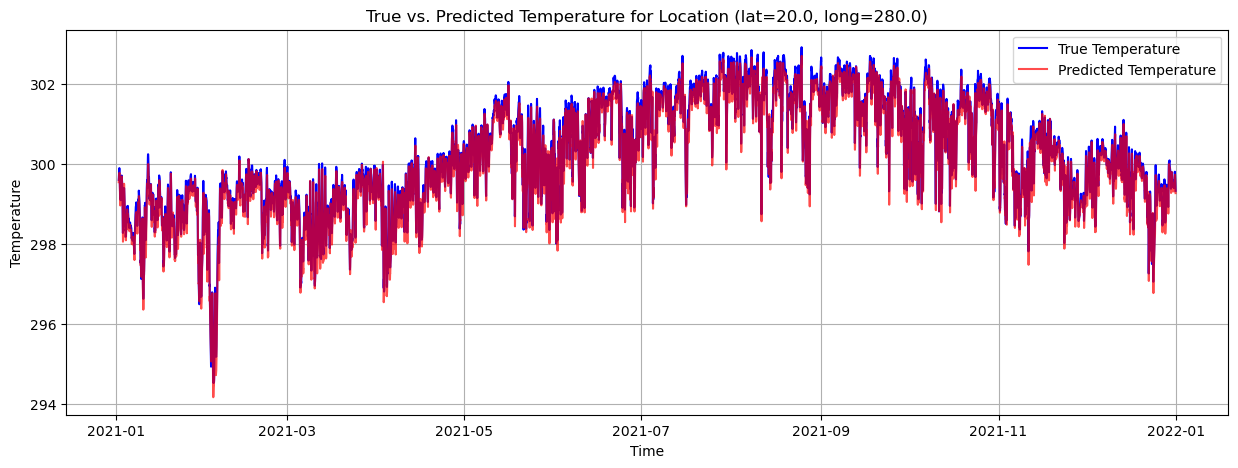

In [15]:
predict_and_plot(test_dataset_loc1, test_loader_loc1, test_times_loc1, location_label="Location (lat=40.0, long=280.0)")
predict_and_plot(test_dataset_loc2, test_loader_loc2, test_times_loc2, location_label="Location (lat=20.0, long=280.0)")